<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6. General Gaussian Filtering

This notebook replicates the figures of Chapter 6 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))

## 6.0 Imports and Pendulum Simulation

In [101]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

In [102]:
# Function to simulate pendulum
def simulate_pendulum(key, m_0, f, Q, h, r, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.normal(rng2) * r
        return next_state, (next_state, obs)

    M = m_0.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [103]:
# Params for pendulum simulation
key = jr.PRNGKey(0)
m_0 = jnp.array([[jnp.pi/2, 0]])
dt = 0.0125
q = 1
g = 9.8
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 0.3
f = lambda x: jnp.array([[x[0,0] + x[0,1]*dt, x[0,1] - g*jnp.sin(x[0,0])*dt]])
h = lambda x: jnp.array([jnp.sin(x[0,0])])

# Simulate pendulum angle
states, obs = simulate_pendulum(key, m_0, f, Q, h, r, 400)

# # Apply arcsin to measured horizontal position to compute measured angle
# obs_angle = jnp.arcsin(jnp.clip(obs[:,0], -1, 1)) 

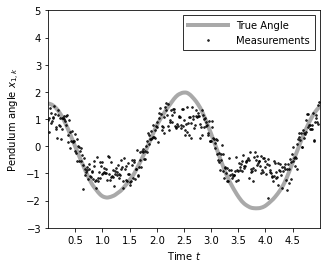

In [104]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

##6.4 Gauss–Hermite Kalman Filter

In [126]:
from numpy.polynomial.hermite import hermgauss
from sklearn.utils.extmath import cartesian

# Additive GHKF (Algorithm 6.7)
def ghkf_additive(m_0, P_0, f, h, Q, R, p, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, sigmas)
        # 2. Propagate the sigma points
        sigmas_pred = jax.vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        m_pred = jnp.tensordot(weights, sigmas_pred, axes=1)
        
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = jax.vmap(outer, 0, 0)
        P_pred = jnp.tensordot(weights, 
                               outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                               axes=1) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, sigmas)
        # 2. Propagate the sigma points
        sigmas_update = jax.vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.tensordot(weights, sigmas_update, axes=1)
        S = jnp.tensordot(weights, 
                        outer(sigmas_update-mu, sigmas_update-mu), 
                        axes=1) + R
        C = jnp.tensordot(weights, 
                        outer(sigmas_pred-m_pred, sigmas_update-mu), 
                        axes=1)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    # Helper functions
    def compute_sigmas(m, P, sigmas):
        # Slightly convoluted way in order to preserve desired dimensions
        devs = jax.vmap(jnp.matmul, [None,0], 0)(jnp.linalg.cholesky(P), sigmas)
        return jax.vmap(jnp.add, [None,0], 0)(m, devs)

    def compute_weights(n, alpha, beta, lamb):
        factor = 1/(2*(n+lamb))
        w_mean = jnp.concatenate((jnp.array([lamb/(n+lamb)]), 
                                  jnp.ones(2*n)*factor))
        w_cov = jnp.concatenate((jnp.array([lamb/(n+lamb) + (1-alpha**2+beta)]),
                                 jnp.ones(2*n)*factor))
        return w_mean, w_cov

    # Compute sigmas and weights
    n = P_0.shape[0]
    num_timesteps = len(Y)
    samples_1d, weights_1d = hermgauss(p)
    weights_1d /= weights_1d.sum()
    sigmas = cartesian(jnp.array([samples_1d] * n))
    weights = jnp.prod(cartesian(jnp.array([weights_1d] * n)), axis=1)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [127]:
# Params for GHKF
m_0 = jnp.array([[jnp.pi/2, 0]])
P_0 = jnp.eye(2)*0.01
f = lambda x: jnp.array([[x[0,0] + x[0,1]*dt, x[0,1] - g*jnp.sin(x[0,0])*dt]])
h = lambda x: jnp.array([jnp.sin(x[0,0])])
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 0.3
p = 1

# Compute GHKF estimates
m_ghkf, P_ghkf = ghkf_additive(m_0, P_0, f, h, Q, r, p, obs)

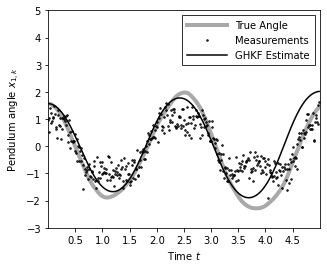

In [128]:
# Plot the generated data (Replicates Figure 6.2)
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_ghkf[:,0,0], color='k', linewidth=1.5, label="GHKF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()